In [158]:
import mne
from scipy.stats import ttest_rel, normaltest
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# subject_ids = range(27, 39)

# Only consider participants with win rate > 60% ("learners") like stated in the original paper:
# > As such, we applied the following a
# > priori criterion: only the data of participants who made a correct response on at least
# > 60% of the learnable trials in both the mid-value task and the high-value task were
# > included in the main EEG analysis

# https://github.com/chassall/averagetaskvalue/blob/main/analysis_05_makeerps.m#L33
subject_ids = [27,28,31,34,35,36,37,38]

In [160]:
win_events = {
    "S  6": "win (low-task, low-cue)",
    "S 16": "win (mid-task, low-cue)",
    "S 26": "win (mid-task, high-cue)",
    "S 36": "win (high-task, high-cue)"
}
loss_events = {
    "S  7": "loss (low-task, low-cue)",
    "S 17": "loss (mid-task, low-cue)",
    "S 27": "loss (mid-task, high-cue)",
    "S 37": "loss (high-task, high-cue)"
}

# Read all win/loss events of all subjects
# Format: 
# key = win/loss type
# value = list of read evokeds of all subjects
win_evokeds = {}
loss_evokeds = {}

for subject_id in subject_ids:
    for event in win_events.values():
        evoked = mne.read_evokeds(f"fif-files/subject{subject_id}_feedback_{event.replace(' ', '-')}-ave.fif")
        evoked[0].set_eeg_reference(["TP9", "TP10"])

        if event not in win_evokeds:
            win_evokeds[event] = []

        win_evokeds[event].append(evoked[0])

    for event in loss_events.values():
        evoked = mne.read_evokeds(f"fif-files/subject{subject_id}_feedback_{event.replace(' ', '-')}-ave.fif")
        evoked[0].set_eeg_reference(["TP9", "TP10"])

        if event not in loss_evokeds:
            loss_evokeds[event] = []
        loss_evokeds[event].append(evoked[0])

# Finally, for every win/loss type, create the grand average of all subjects
wins_combined = {}
for event in win_events.values():
    wins_combined[event] = mne.grand_average(win_evokeds[event])

losses_combined = {}
for event in loss_events.values():
    losses_combined[event] = mne.grand_average(loss_evokeds[event])

Reading /home/mark/EEGproject/fif-files/subject27_feedback_win-(low-task,-low-cue)-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms (6)
        0 CTF compensation matrices available
        nave = 72 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Reading /home/mark/EEGproject/fif-files/subject27_feedback_win-(mid-task,-low-cue)-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms (16)
        0 CTF compensation matrices available
        nave = 29 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Reading /home/mark/EEGpro

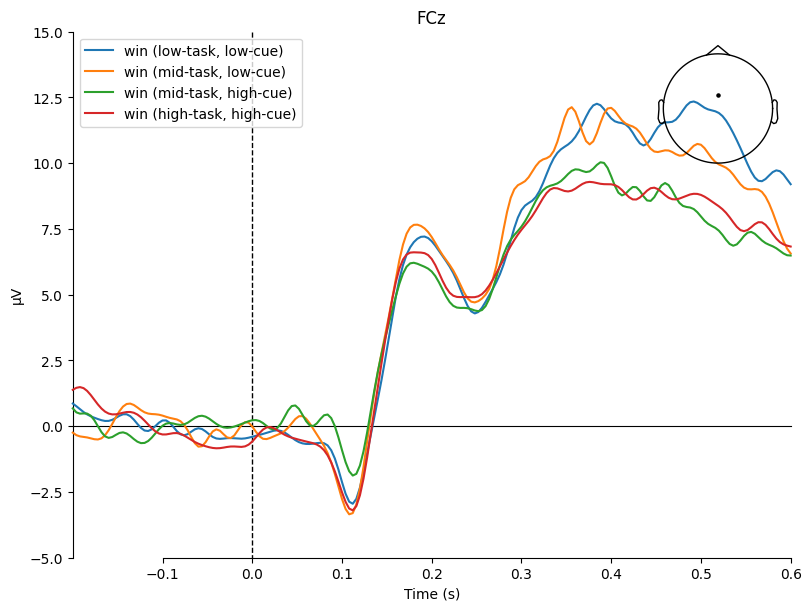

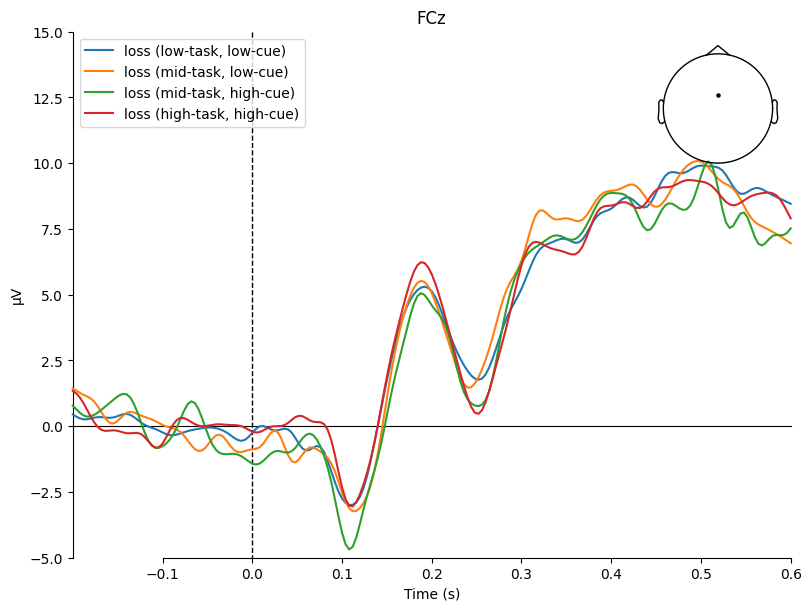

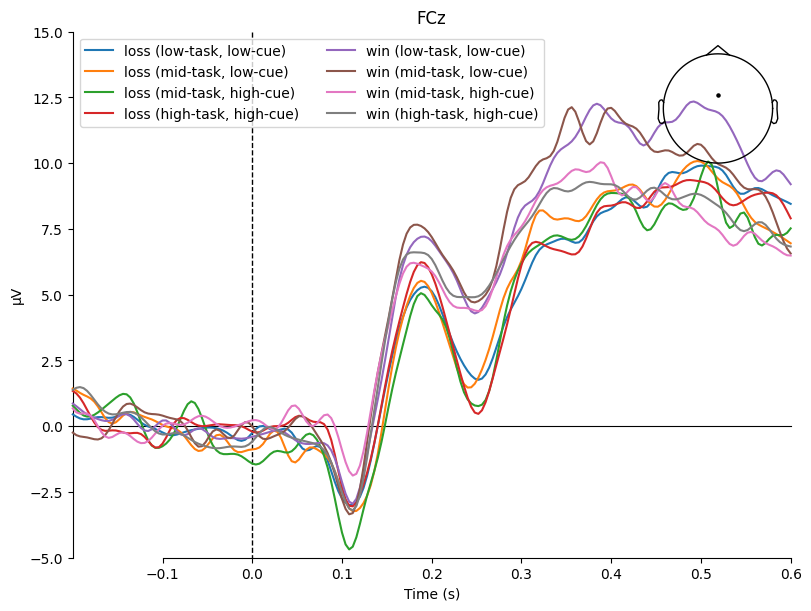

[<Figure size 800x600 with 2 Axes>]

In [161]:
mne.viz.plot_compare_evokeds(wins_combined, picks="FCz", ylim=dict(eeg=[-5, 15]))
mne.viz.plot_compare_evokeds(losses_combined, picks="FCz", ylim=dict(eeg=[-5, 15]))
mne.viz.plot_compare_evokeds({**losses_combined, **wins_combined}, picks="FCz", 
    ylim=dict(eeg=[-5, 15]))

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


/home/mark/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


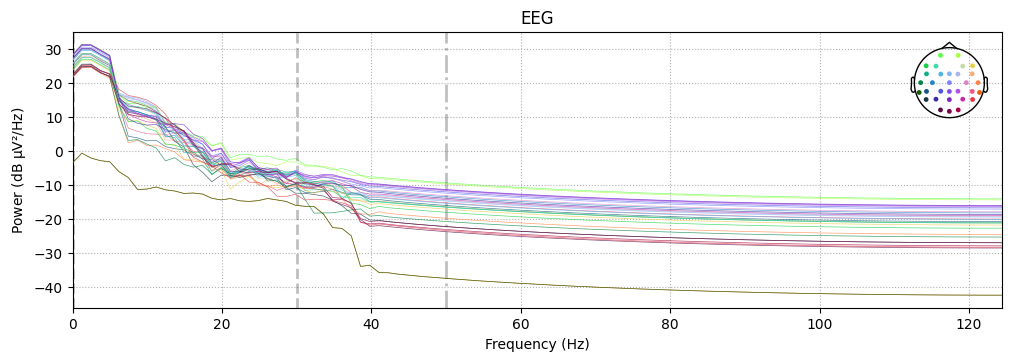

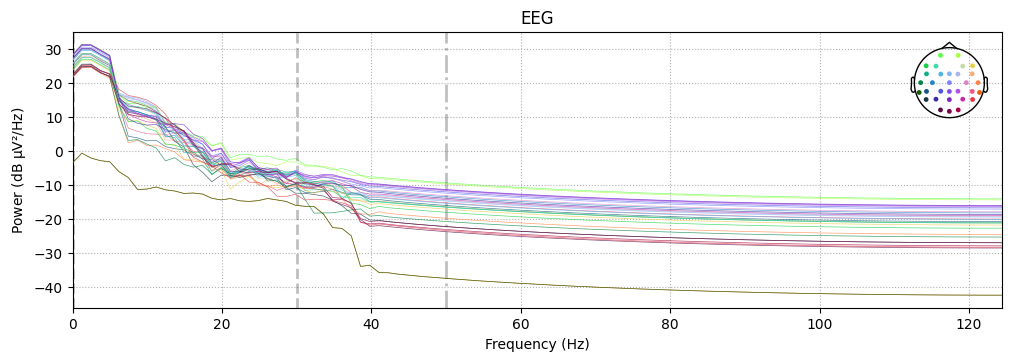

In [162]:
wins_combined["win (high-task, high-cue)"].compute_psd().plot()

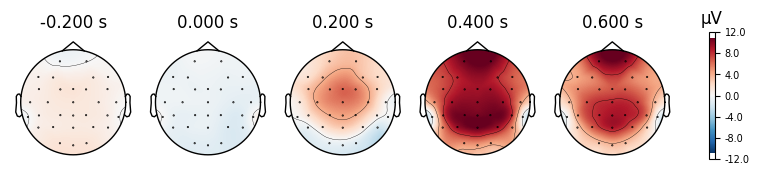

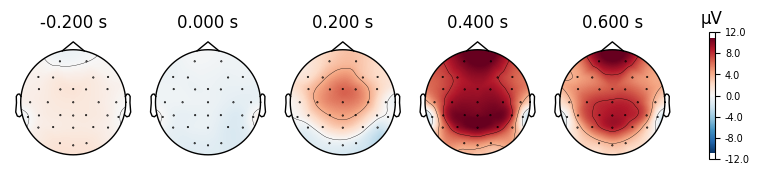

In [163]:
wins_combined["win (high-task, high-cue)"].plot_topomap(times=[-0.2, 0, 0.2, 0.4, 0.6])

No projector specified for this dataset. Please consider the method self.add_proj.


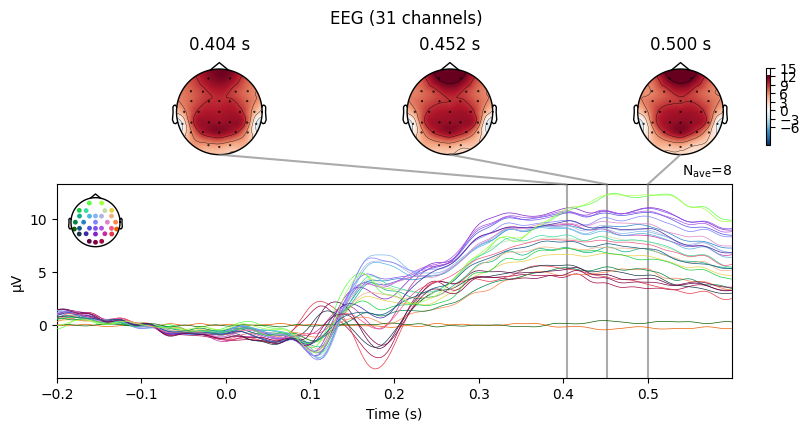

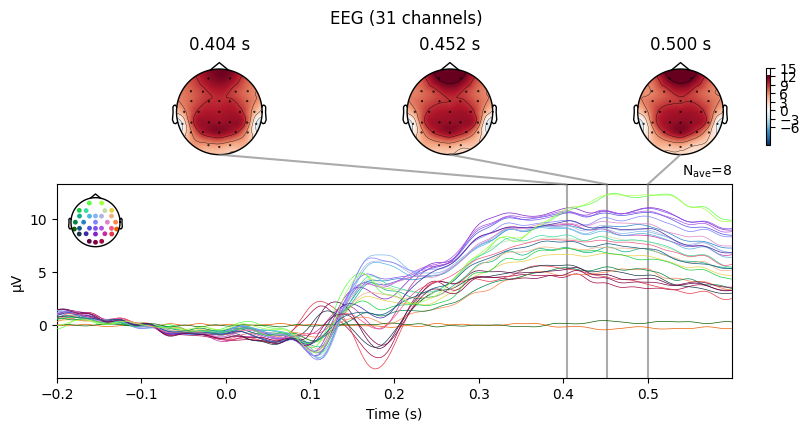

In [164]:
wins_combined["win (high-task, high-cue)"].plot_joint()


In [165]:
# TODOS
# 1. difference curve like in the paper
# 2. t-test + cohen's d between these curves

In [166]:

# diff_curve = mne.combine_evoked([losses_combined["loss (low-task, low-cue)"], wins_combined["win (low-task, low-cue)"]], weights=[1, -1])
# diff_curve_mid_low = mne.combine_evoked([losses_combined["loss (mid-task, low-cue)"], wins_combined["win (mid-task, low-cue)"]], weights=[1, -1])
# diff_curve_mid_high = mne.combine_evoked([losses_combined["loss (mid-task, high-cue)"], wins_combined["win (mid-task, high-cue)"]], weights=[1, -1])
# diff_curve_high = mne.combine_evoked([losses_combined["loss (high-task, high-cue)"], wins_combined["win (high-task, high-cue)"]], weights=[1, -1])
# # diff_curve.plot(picks="FCz")
# mne.viz.plot_compare_evokeds([diff_curve, diff_curve_mid_low, diff_curve_mid_high, diff_curve_high], picks=["FCz"])

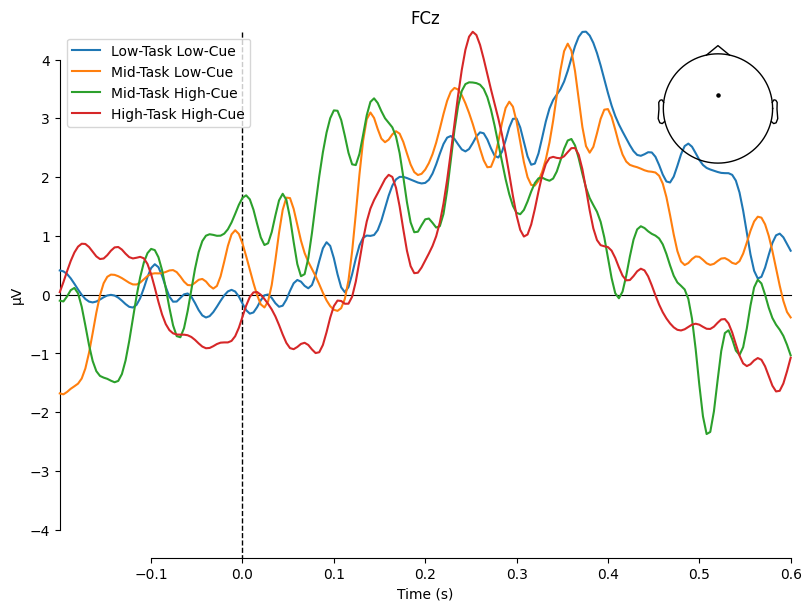

[<Figure size 800x600 with 2 Axes>]

In [167]:
diff_curve_low = mne.combine_evoked([wins_combined["win (low-task, low-cue)"], losses_combined["loss (low-task, low-cue)"]], weights=[1, -1])
diff_curve_mid_low = mne.combine_evoked([wins_combined["win (mid-task, low-cue)"], losses_combined["loss (mid-task, low-cue)"]], weights=[1, -1])
diff_curve_mid_high = mne.combine_evoked([wins_combined["win (mid-task, high-cue)"], losses_combined["loss (mid-task, high-cue)"]], weights=[1, -1])
diff_curve_high = mne.combine_evoked([wins_combined["win (high-task, high-cue)"], losses_combined["loss (high-task, high-cue)"]], weights=[1, -1])

mne.viz.plot_compare_evokeds(
    {"Low-Task Low-Cue": diff_curve_low, 
     "Mid-Task Low-Cue": diff_curve_mid_low, 
     "Mid-Task High-Cue": diff_curve_mid_high, 
     "High-Task High-Cue": diff_curve_high},
    picks="FCz",
    # ylim=dict(eeg=[-5, 5])
)


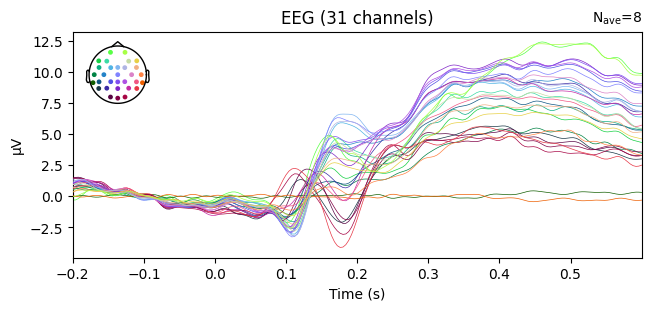

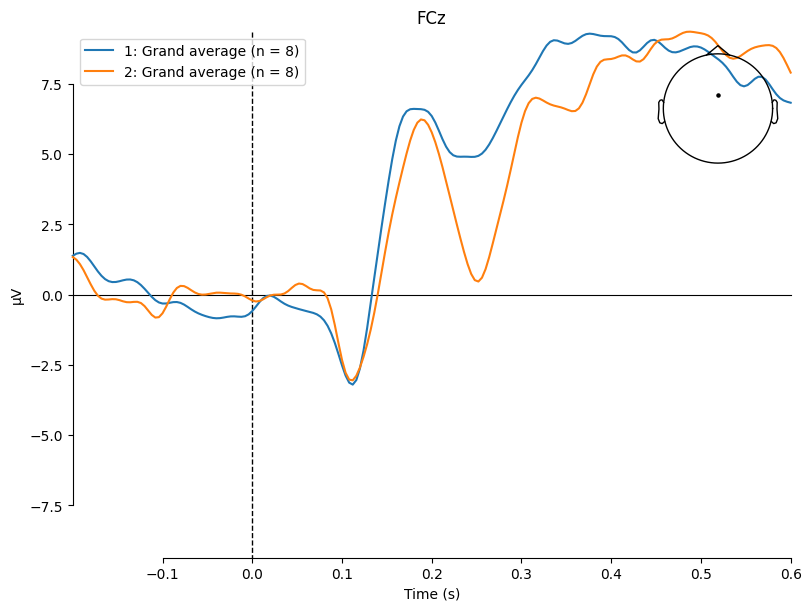

[<Figure size 800x600 with 2 Axes>]

In [168]:
wins_combined["win (high-task, high-cue)"].plot()
mne.viz.plot_compare_evokeds([wins_combined["win (high-task, high-cue)"], losses_combined["loss (high-task, high-cue)"] ], picks="FCz")

#### low vs mid-low

In [169]:
# _, _, low_peak = diff_curve_low.pick("FCz").get_peak(ch_type='eeg', mode='pos', tmin=0.2, tmax=0.4, return_amplitude=True)
# _, _, mid_low_peak = diff_curve_mid_low.pick("FCz").get_peak(ch_type='eeg', mode='pos', tmin=0.2, tmax=0.4, return_amplitude=True)

data_low_task = diff_curve_low.get_data(picks="FCz", tmin=0.2, tmax=0.4)[0]
data_mid_low_task = diff_curve_mid_low.get_data(picks="FCz", tmin=0.2, tmax=0.4)[0]

# print(data_low_task)
# print(data_mid_low_task)

t_stat, p_val  = ttest_rel(data_low_task, data_mid_low_task)
print(p_val)

0.24508646322229813


In [170]:
print(normaltest(data_low_task))
print(normaltest(data_mid_low_task))
# plt.hist(data_low_task)


NormaltestResult(statistic=6.154387531695136, pvalue=0.046088410217494)
NormaltestResult(statistic=1.9603575687586692, pvalue=0.37524400508737116)


(array([5., 8., 5., 6., 7., 8., 6., 0., 2., 3.]),
 array([1.85640785e-06, 2.09773633e-06, 2.33906481e-06, 2.58039329e-06,
        2.82172177e-06, 3.06305025e-06, 3.30437873e-06, 3.54570721e-06,
        3.78703569e-06, 4.02836417e-06, 4.26969265e-06]),
 <BarContainer object of 10 artists>)

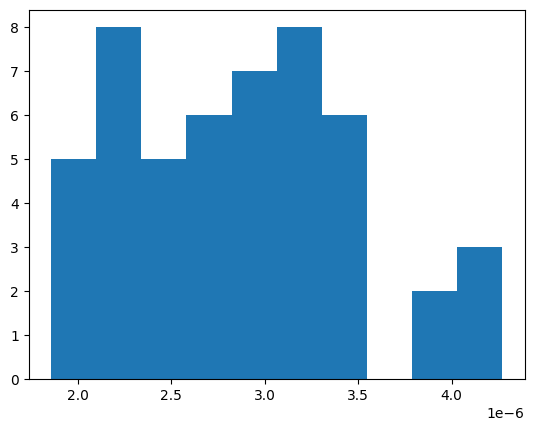

In [171]:
plt.hist(data_mid_low_task)

In [172]:
differences_low_mid = mne.combine_evoked([diff_curve_low, diff_curve_mid_low], weights=[1, -1])

differences_low_mid = differences_low_mid.get_data(picks="FCz")

# Compute the mean difference and its standard deviation (ddof=1 for sample std)
mean_diff = np.mean(differences_low_mid)

std_diff = np.std(differences_low_mid, ddof=1)
print(mean_diff, std_diff)

# Cohen's d for paired samples
cohen_d = mean_diff / std_diff

print("Cohen's d =", cohen_d)

7.537095371408494e-08 9.164770845346571e-07
Cohen's d = 0.08223986718921039


#### mid-high vs high

In [173]:
# _, _, mid_high = diff_curve_mid_high.pick("FCz").get_peak(ch_type='eeg', mode='pos', tmin=0.2, tmax=0.4, return_amplitude=True)
# _, _, high_peak = diff_curve_high.pick("FCz").get_peak(ch_type='eeg', mode='pos', tmin=0.2, tmax=0.4, return_amplitude=True)

# TODO: https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html#mean-amplitude


data_mid_high_task = diff_curve_mid_high.get_data(picks="FCz", tmin=0.2, tmax=0.4)[0]
data_high_task = diff_curve_high.get_data(picks="FCz", tmin=0.2, tmax=0.4)[0]

print(normaltest(data_mid_high_task))
print(normaltest(data_high_task))

# print(data_mid_high_task)
# print(data_high_task)

t_stat, pvalue = ttest_rel(data_high_task, data_mid_high_task)
print(pvalue)

NormaltestResult(statistic=6.297313088707207, pvalue=0.042909735487488346)
NormaltestResult(statistic=3.909763248316291, pvalue=0.14158123550013874)
0.2431314003899369


#### How big is the effect? -> Cohen's d

In [174]:
differences = mne.combine_evoked([diff_curve_high, diff_curve_mid_high], weights=[1, -1])

differences = differences.get_data(picks="FCz")

# Compute the mean difference and its standard deviation (ddof=1 for sample std)
mean_diff = np.mean(differences)

std_diff = np.std(differences, ddof=1)
print(mean_diff, std_diff)

# Cohen's d for paired samples
cohen_d = mean_diff / std_diff

print("Cohen's d =", cohen_d)

-4.844715439520016e-07 1.2046014499711823e-06
Cohen's d = -0.40218409496650664
